In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
from botorch.test_functions.multi_objective import BraninCurrin
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

tkwargs = {"device": "cuda", "dtype": torch.float}

In [3]:
def generate_initial_data(problem, n=6):
    # generate training data
    X_obs = torch.empty(0, problem.bounds.shape[-1], **tkwargs)
    y_obs = torch.empty(0, problem.ref_point.shape[-1], **tkwargs)
    while len(X_obs) < n:
        x = draw_sobol_samples(bounds=problem.bounds, n=1, q=1).squeeze(1)
        y = problem(x)
        if (y > problem.ref_point).all(dim=-1).item():
            X_obs = torch.concat([X_obs, x], dim=0)
            y_obs = torch.concat([y_obs, y], dim=0)

    return X_obs, y_obs

In [4]:
problem = BraninCurrin(negate=True).to(**tkwargs)
print(f"max_hv: {problem.max_hv}\nref_point: {problem.ref_point}")
X_obs, y_obs = generate_initial_data(problem, n=500)

max_hv: 59.36011874867746
ref_point: tensor([-18.,  -6.], device='cuda:0')


In [5]:
# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

## Hypervolume scalarization

$$ \mathcal{HV}_{z}(Y) := c_k \mathbb{E}_{\lambda \sim \mathcal{S}_{+}^{k-1}} \left[ \max_{y \in Y} s_{\lambda}(y - z) \right] $$

where $s_{\lambda}(y) = \min_i(\max(0, \frac{y_i}{\lambda_i}))^k$ and $c_k = \frac{\pi^{k/2}}{2^k \Gamma (k / 2+1)}$. $ \mathcal{S}_{+}^{k-1} = \{ \lambda \in \mathbb R^k \mid \lVert \lambda \rVert= 1, \lambda \geq 0 \} $ (from a hypersphere)

In [6]:
from botorch.utils.sampling import sample_hypersphere

In [7]:
# Ground truth
volume = bd.compute_hypervolume().item()
print(volume)

56.109039306640625


In [8]:
k = torch.tensor(y_obs.shape[-1])

In [9]:
hv_weights = sample_hypersphere(d=k, n=100, qmc=True).abs().unsqueeze(1).to(**tkwargs)
# dimension-independent constant
c_k = torch.pow(torch.pi, k / 2) / (torch.pow(torch.tensor(2), k) * torch.lgamma(k/2 + 1).exp())

In [10]:
# hypervolume scalarization
y = y_obs
scalar = ((y - problem.ref_point).clamp_min(0).unsqueeze(-3) / hv_weights).amin(dim=-1).pow(k).amax(dim=-1)
hv_scalar = c_k * scalar.mean()
print(hv_scalar.item())

54.17313766479492


### Deep random hypervolume scalarization

In [11]:
import torch
import torch.nn as nn

from modules import SAB, PMA, ISAB


def gen_data(dataset, batch_size):
    # number of y in a set
    max_length = dataset.tensors[0].shape[0]
    length = torch.randint(low=1, high=max_length + 1, size=(1,)).item()
    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=length,
        shuffle=True,
        drop_last=True,
    )

    def inf_train_gen(dataloader):
        while True:
            for y in iter(dataloader): yield y

    train_gen = inf_train_gen(trainloader)
    y_samples = torch.empty(0, length, dataset.tensors[0].shape[-1], **tkwargs)
    for _ in range(batch_size):
        data = next(train_gen)
        data = data[0].unsqueeze(0)
        y_samples = torch.concat([y_samples, data], dim=0)

    weight_samples = sample_hypersphere(d=k, n=batch_size, qmc=True).abs().unsqueeze(1).to(**tkwargs)
    return y_samples, weight_samples

class SetTransformer(nn.Module):
    def __init__(self, dim_input=2, num_outputs=1, dim_output=1,
            num_inds=32, dim_hidden=128, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X)).squeeze(-1)

class SmallSetTransformer(nn.Module):
    def __init__(self,):
        super().__init__()
        self.enc = nn.Sequential(
            SAB(dim_in=2, dim_out=64, num_heads=4),
            SAB(dim_in=64, dim_out=64, num_heads=4),
        )
        self.dec = nn.Sequential(
            PMA(dim=64, num_heads=4, num_seeds=1),
            nn.Linear(in_features=64, out_features=1),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1)

def train_model(model, y_obs, num_iter=500):
    y_dataset = torch.utils.data.TensorDataset(y_obs)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    criterion = torch.nn.functional.binary_cross_entropy_with_logits
    losses = []
    batch_size = 32
    
    model.train()
    for i in range(num_iter):
        if (i+1) % 100 == 0:
            print(f"iteration {i+1}")
    
        y_samples, hv_weights = gen_data(dataset=y_dataset, batch_size=batch_size)

        u = torch.tensor([], **tkwargs)
        for y, w in zip(y_samples, hv_weights):
            u = torch.concat([u, utility(w[None, ...], y[None, ...])])
    
        labels = torch.concat([torch.ones_like(u), torch.zeros_like(u)])
        u = torch.concat([u, torch.ones_like(u)])
    
        input = torch.concat([y_samples, y_samples])
    
        preds = model(input)
        loss = criterion(preds, labels, weight=u)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step()
    model.eval()
    return model, losses

In [12]:
def utility(hv_weights, y):
    return ((y - problem.ref_point).clamp_min(0).unsqueeze(-3) / hv_weights).amin(dim=-1).pow(k).amax(dim=-1)

iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900
iteration 1000


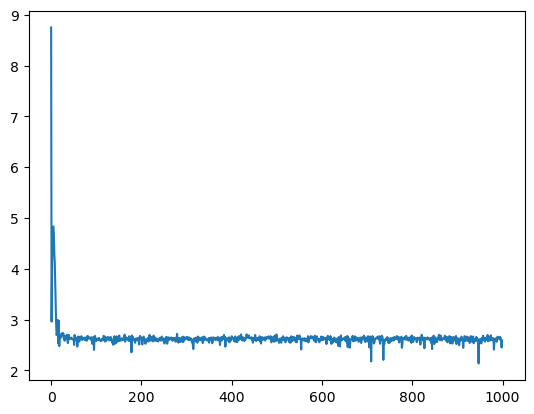

In [13]:
model = SmallSetTransformer()
model.to(**tkwargs)
train = True

if train:
    model, losses = train_model(model, y_obs, num_iter=1000)
    torch.save(model.state_dict(), "/home/paj7rng/mobo_experiments/demos/lfbo/set_transformer.pt")

    import matplotlib.pyplot as plt
    plt.plot(losses);
else:
    model.load_state_dict(torch.load("/home/paj7rng/mobo_experiments/demos/lfbo/set_transformer.pt"))
    model.eval()

In [14]:
with torch.no_grad():
    pred = torch.sigmoid(model(y_obs[None, ...]))
hypervolume = c_k * pred / (1 - pred)

print(volume)
print(hv_scalar.item())
print(hypervolume.item())

56.109039306640625
54.17313766479492
53.22073745727539


In [15]:
with torch.no_grad():
    pred = torch.sigmoid(model(y_obs[None, ...]))

In [16]:
hvs_diff = []
hvd_diff = []
for n in range(10, 110, 10):
    _, y_obs = generate_initial_data(problem, n=n)
    
    # Ground truth
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    volume = bd.compute_hypervolume().item()

    
    # hypervolume scalarization
    y = y_obs
    scalar = ((y - problem.ref_point).clamp_min(0).unsqueeze(-3) / hv_weights).amin(dim=-1).pow(k).amax(dim=-1)
    hv_scalar = c_k * scalar.mean()
    hvs_diff.append(abs(volume - hv_scalar.item()))
    
    # DeepHV
    with torch.no_grad():
        pred = torch.sigmoid(model(y_obs[None, ...]))
    hypervolume = c_k * pred / (1 - pred)
    hvd_diff.append(abs(volume - hypervolume.item()))

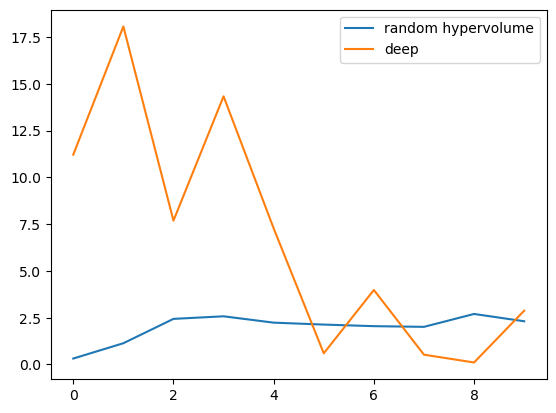

In [17]:
import matplotlib.pyplot as plt

plt.plot(hvs_diff, label="random hypervolume")
plt.plot(hvd_diff, label="deep")
plt.legend();